Using the [TED Talks](https://www.kaggle.com/datasets/rounakbanik/ted-talks?resource=download) dataset. 

Following a [towardsdatascience.com](https://towardsdatascience.com/nlp-topic-modeling-to-identify-clusters-ca207244d04f) tutorial.

[How to install the en_core_web_lg](https://www.datasciencelearner.com/how-to-install-en_core_web_lg-spacy-model/)

[Tutorial notebook link](https://github.com/gaurikatyagi/Natural-Language-Processing/blob/master/Introdution%20to%20NLP-Clustering%20Text.ipynb)

[secondary topic modeling tutorial](https://towardsdatascience.com/building-a-topic-modeling-pipeline-with-spacy-and-gensim-c5dc03ffc619)

[spacy setup](https://spacy.io/usage)

According to [DZone.com](https://dzone.com/articles/lda-for-text-summarization-and-topic-detection) LDA is an unsupervised algorithm for isolating the top K topics in a data set as described by the most relevant N keywords. I.E., the documents in the data are represented as a random mix of topics. Each of these topics is represented by a Dirichlet distribution over a fixed vocabulary. Latent means that the topics must be inferred.

LDA is a generative model. This raises some assumptions:
- word order is not important
- document order in the dataset is not important
- number of topics must be known in advance
- the same word can be in multiple topics
- each document in the total collection of D documents is a mix of K latent topics.
- Each topic has a multinomial distribution over a vocabulary of words w.

Need to pre-extract the keywords from the documents. Some good extractors are Chi-square, tfidf frequency measures, or bag of words.
- LDA can be used for topic extraction. 
- keywords are returned with weights.
- we can then report the keywords and their weights to a wordcloud to get an idea of what topics are most prevalent.

Sounds like LDA may or may not work as it needs a lot of keywords fed in and if those keywords are changed it would need to be retrained each time... This could lead to high compute costs.

This [Science Direct Paper](https://www.sciencedirect.com/science/article/pii/S1877050918315138) says that it may be wise to use K-Means to cluster the document then use LDA-Significant Sentences to generate summaries.

This [Toward Data Science](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2) article confirms the assumptions.
- can remove words that are common to all documents
- know number of topics beforehand.

LDA works by itteratively checking the probability that words belong with given topics. It repeats this until convergence, at which point there will be accurate scores for each word with respect to each topic.
- I.E., for the two topics 'Nature' and 'City' it would start by assigning 'tree' to 'Nature' and then would lower its probability once it determines trees can be inside cities as well.

## Overall
Overall it seems like LDA may be usefull to classify lecturs based on their subjects. This would then let us use specialized summarization tools for each subject. On the other hand, multiple research papers, like [this one](https://ieeexplore.ieee.org/abstract/document/8371951) say LDA can be used for summarization.

## Import Libraries

In [2]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import pandas as pd

from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from gensim.models.ldamodel import LdaModel
# from gensim import matuitils

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

import os
import re
from collections import defaultdict
# python -m spacy download en_core_web_lg
import en_core_web_lg
import sys

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.pipeline.ner import DEFAULT_NER_MODEL
from spacy.language import Language
# load spacy model, can be "en_core_web_sm" as well
# python -m spacy download en_core_web_sm
# 12.8Mb for small, 587.7Mb for large
nlp = spacy.load('en_core_web_lg')

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# https://github.com/microsoft/vscode-jupyter/issues/11014
# TQDM requires version between 7 and 8, not version 8+.
from tqdm.notebook import tqdm as tqdm
tqdm.pandas()
from pprint import pprint

import gensim
from gensim.models import TfidfModel
import pyLDAvis
import pyLDAvis.gensim_models # https://github.com/bmabey/pyLDAvis/issues/131#issuecomment-805164485
pyLDAvis.enable_notebook()
# from gensim.summarization import summarize ## CANNOT USE THIS! REMOVED IN GENSIM 4.0

import sumy

from bs4 import BeautifulSoup
import unidecode
from word2number import w2n
import contractions

from wordcloud import WordCloud

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from Preprocessing import Preprocessor
preprocessor = Preprocessor(1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fassg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fassg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [3]:
config = {
   "moves": None,
   "update_with_oracle_cut_size": 100,
   "model": DEFAULT_NER_MODEL,
   "incorrect_spans_key": "incorrect_spans",
}
new_name = 'ner'
if not new_name in nlp.pipe_names:
    nlp.add_pipe(new_name, config=config)
new_name = 'merge_noun_chunks'
if not new_name in nlp.pipe_names:
    # https://stackoverflow.com/questions/53598243/is-there-a-bi-gram-or-tri-gram-feature-in-spacy
    nlp.add_pipe("merge_noun_chunks")
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'merge_noun_chunks']


## Load the Dataset
This section will also include joining the two together.

In [5]:
print(os.getcwd())
BASE_PATH = '..\\Datasets\\TEDTalksDataset'
# ted_main_path = '..\\Datasets\\TEDTalksDataset\\ted_main.csv'
# transcripts_path = '..\\Datasets\\TEDTalksDataset\\transcripts.csv'
ted_main_path = os.path.abspath("..\\Datasets\\TEDTalksDataset\\ted_main.csv")
transcripts_path = os.path.abspath("..\\Datasets\\TEDTalksDataset\\transcripts.csv")
ted_main = pd.read_csv(ted_main_path)
transcripts = pd.read_csv(transcripts_path)

c:\lwshare\TranscriptionStudyAssistant\MachineLearningModels


In [4]:
ted_main.head(1)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110


In [5]:
transcripts.head(1)

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...


In [6]:
df = ted_main.join(transcripts, lsuffix='url', rsuffix='url')
df.head(1)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,urlurl,views,transcript,urlurl
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...


In [7]:
print("TITLE: %s, TRANSCRIPT DTYPE: %s, TRANSCRIPT LENGTH: %s" % (df['title'][0], type(df['transcript'][0]), len(df['transcript'][0])))
# print(df['transcript'][0])
# transcript  = df['transcript'][0]

TITLE: Do schools kill creativity?, TRANSCRIPT DTYPE: <class 'str'>, TRANSCRIPT LENGTH: 17409


In [8]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2550 non-null   int64 
 1   description         2550 non-null   object
 2   duration            2550 non-null   int64 
 3   event               2550 non-null   object
 4   film_date           2550 non-null   int64 
 5   languages           2550 non-null   int64 
 6   main_speaker        2550 non-null   object
 7   name                2550 non-null   object
 8   num_speaker         2550 non-null   int64 
 9   published_date      2550 non-null   int64 
 10  ratings             2550 non-null   object
 11  related_talks       2550 non-null   object
 12  speaker_occupation  2544 non-null   object
 13  tags                2550 non-null   object
 14  title               2550 non-null   object
 15  urlurl              2550 non-null   object
 16  views               2550

The above check shows that we will need to remove rows with null values for transcripts

In [9]:
df = df.dropna()
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2461 entries, 0 to 2466
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2461 non-null   int64 
 1   description         2461 non-null   object
 2   duration            2461 non-null   int64 
 3   event               2461 non-null   object
 4   film_date           2461 non-null   int64 
 5   languages           2461 non-null   int64 
 6   main_speaker        2461 non-null   object
 7   name                2461 non-null   object
 8   num_speaker         2461 non-null   int64 
 9   published_date      2461 non-null   int64 
 10  ratings             2461 non-null   object
 11  related_talks       2461 non-null   object
 12  speaker_occupation  2461 non-null   object
 13  tags                2461 non-null   object
 14  title               2461 non-null   object
 15  urlurl              2461 non-null   object
 16  views               2461

Shorten the dataset for now due to performance issues when training locally

In [10]:
# df = df.head()
df = df[0:30]
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            30 non-null     int64 
 1   description         30 non-null     object
 2   duration            30 non-null     int64 
 3   event               30 non-null     object
 4   film_date           30 non-null     int64 
 5   languages           30 non-null     int64 
 6   main_speaker        30 non-null     object
 7   name                30 non-null     object
 8   num_speaker         30 non-null     int64 
 9   published_date      30 non-null     int64 
 10  ratings             30 non-null     object
 11  related_talks       30 non-null     object
 12  speaker_occupation  30 non-null     object
 13  tags                30 non-null     object
 14  title               30 non-null     object
 15  urlurl              30 non-null     object
 16  views               30 non-n

## Cleaning and Preprocessing Section
There are a few common preprocessing steps that can be performed. Some were found from [this TowardsDataScience article](https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79).

0. Extra Preprocessing Depending on Source
    - Remove HTML tags
    - Convert accented characters to ASCII characters
1. Contraction Expansion
    - expand contractions so that they are two words instead of one.
2. Convert Word Form of Numbers to Numerics
    - i.e., convert four thousand to 4000
3. Optionally may want to remove numbers altogether.
4. Remove Special Characters
5. Tokenization
    - This involves splitting the text into sentences and then splitting the sentences into words.
    - `from nltk.tokenize import word_tokenize`
    - `words = word_tokenize(sentence)`
6. Punctuation Cleaning
    - This involves cleaning all of the punctuation out of the words.
7. Short Word Removal
    - This involves removing all of the words that are shorter than 3 characters as they are commonly not useful.
    - Note that this is done before the case cleaning so that a check can be performed if all letters are capitalized which would signify an acronym.
8. Case Cleaning
    - This involves making all of the words the same case. Usually lower case.
    - `sentence = sentence.lower()`
9. Stopword Removal
    - This involves removing all of the stopwords from the text. Stop Words are a set of commonly used words in language. These words are so common that they carry very little useful information.
    - Note that some stopwords are actually important to the meaning of the text and may want to be added back in. I.E., the word 'not' in sentiment analysis.
    - `from nltk.corpus import stopwords`
    - `stop_words = set(stopwords.words('english'))`
    - `filtered_sentence = [w for w in word_tokens if not w in stop_words]`
10. Lemmatization
    - change all of the third person words to first person
    - change all verbs in past and future tenses to present tense.
    - `fron nltk.stem import WordNetLemmatizer`
    - `lemmatizer = WordNetLemmatizer()`
    - `lemmatizer.lemmatize('Machine", pos='n')`
11. Stemming
    - reduce words to their root form.
    - May not always be wanted as it can reduce words to far so that they are no longer words and no longer make sense. I.E., 'machine' -> 'machin'
    - `from nltk.stem import PorterStemmer`
    - `ps = PorterStemmer()`
    - `ps.stem(word)`
12. Remove Extra Whitespace

In [11]:
text = df['transcript'][0]


deselect_stop_words = []#['no', 'not']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False
    
add_stop_words = ['go', 'say', 'come']
for w in add_stop_words:
    nlp.vocab[w].is_stop = True

def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text

def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

def add_spaces_around_parens(text, remove_actions=True):
    remove_list = ['(Laughter)', '(laughter)', '(Music)', '(music)', '(Music ends)', '(Audience cheers)', '(Applause)', '(Applause ends)', '(Applause continues)', '(Bells)', '(Trumpet)', '(Clears throat)']
    for i in remove_list:
        text = text.replace(i, ' ')
    text = text.replace("(", " (")
    text = text.replace(")", ") ")
    return text.replace("  ", ' ')

def fix_punctuation_spacing(text):
    # https://stackoverflow.com/questions/44263446/python-regex-to-add-space-after-dot-or-comma
    # text = text.replace('\\w\\.\\w')
    text = re.sub(r'(?<=[.,?])(?=[^\s])', r' ', text)
    return text

def text_preprocessing(text, accented_chars=True, contractions=True, 
                       convert_num=True, extra_whitespace=True, 
                       lemmatization=True, remove_short_words=True, lowercase=True, punctuations=True,
                       remove_html=True, remove_num=True, special_chars=True, 
                       stop_words=True, get_doc=False):
    """preprocess text with default option set to true for all steps"""
    text = add_spaces_around_parens(text)
    text = fix_punctuation_spacing(text)
    if remove_html == True: #remove html tags
        text = strip_html_tags(text)
    if extra_whitespace == True: #remove extra whitespaces
        text = remove_whitespace(text)
    if accented_chars == True: #remove accented characters
        text = remove_accented_chars(text)
    if contractions == True: #expand contractions
        text = expand_contractions(text)
    if lowercase == True: #convert all characters to lowercase
        text = text.lower()

    doc = nlp(text) #tokenise text
    
    
    # merge_noun_chunks=True,
    # if merge_noun_chunks == True:
    #     for noun_phrase in list(doc.noun_chunks):
    #         noun_phrase.merge(noun_phrase.root.tag_, noun_phrase.root.lemma_, noun_phrase.root.ent_type_)
                              
#                               temp_doc = text_preprocessing(df['transcript'][0], get_doc=True)
# list(temp_doc.noun_chunks)


    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM': 
            flag = False
        # remove punctuations
        if punctuations == True and token.pos_ == 'PUNCT' and flag == True: 
            flag = False
        # remove special characters
        if special_chars == True and token.pos_ == 'SYM' and flag == True: 
            flag = False
        # remove numbers
        if remove_num == True and (token.pos_ == 'NUM' or token.text.isnumeric()) \
        and flag == True:
            flag = False
        # convert number words to numeric numbers
        if convert_num == True and token.pos_ == 'NUM' and flag == True:
            edit = w2n.word_to_num(token.text)
            token.text = edit # may cause issues. Unsure
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list 
        if edit != "" and flag == True and (remove_short_words == True and len(token.text) > 3):
            clean_text.append(edit)    
    if not get_doc:    
        return clean_text
    else:
        return doc

# print(text_preprocessing(text))
# print(stop_words)

In [20]:
type(preprocessor.clean(df['transcript'][0], get_doc=True))

spacy.tokens.doc.Doc

In [12]:
%%time
# pip install ipywidgets widgetsnbextension pandas-profiling
texts = df['transcript']
doc_list = []
# Iterates through each article in the corpus.
for doc in tqdm(texts):
    # Passes that article through the pipeline and adds to a new list.
    # pr = nlp(doc)
    # doc_list.append(text_preprocessing(doc))
    doc_list.append(preprocessor.clean(doc))
    
doc_list[0][0:10]

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: total: 18.9 s
Wall time: 19.1 s


['good morning',
 'great',
 'blow',
 'away',
 'the whole thing',
 'fact',
 'leave',
 'three theme',
 'run',
 'the conference']

## Perform basic topic modeling according to [this tutorial](https://towardsdatascience.com/building-a-topic-modeling-pipeline-with-spacy-and-gensim-c5dc03ffc619).
May want to try setting up each sentence as its own document instead of the transcript as a whole being a document.

The gensim doc2bow step may be able to be improved as per [this tutorial](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

Improvements made according to [this video](https://www.youtube.com/watch?v=UEn3xHNBXJU&ab_channel=PythonTutorialsforDigitalHumanities)

In [13]:
# Creates, which is a mapping of word IDs to words.
# temp = [doc_list[0]]
temp = doc_list
words = corpora.Dictionary(temp)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in temp]

In [14]:
drop_common_words = True
if drop_common_words:
    tfidf = TfidfModel(corpus, id2word=words)
    low_value = 0.03
    tfidf_words = []
    words_missing_in_tfidf = []

    low_value = 0.025

    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = [] #reinitialize to be safe. You can skip this.
        tfidf_ids = [id for id, value in tfidf[bow]]
        bow_ids = [id for id, value in bow]
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        drops = low_value_words+words_missing_in_tfidf
        for item in drops:
            tfidf_words.append(words[item])
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  

        #reassign        
        corpus[i] = new_bow
        
    print(words_missing_in_tfidf)

[140, 215, 272, 278, 573, 611]


In [15]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=30, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.000*"the universe" + 0.000*"happiness" + 0.000*"woman" + '
  '0.000*"knowledge" + 0.000*"talk" + 0.000*"dark" + 0.000*"true" + '
  '0.000*"billion" + 0.000*"survive" + 0.000*"life"'),
 (7,
  '0.000*"the world" + 0.000*"howard" + 0.000*"build" + 0.000*"develop" + '
  '0.000*"imagine" + 0.000*"woman" + 0.000*"create" + 0.000*"people" + '
  '0.000*"the universe" + 0.000*"coffee"'),
 (25,
  '0.000*"the world" + 0.000*"people" + 0.000*"film" + 0.000*"woman" + '
  '0.000*"change" + 0.000*"build" + 0.000*"watch" + 0.000*"show" + 0.000*"the '
  'universe" + 0.000*"middle world"'),
 (3,
  '0.000*"wikipedia" + 0.000*"the world" + 0.000*"the community" + 0.000*"the '
  'building" + 0.000*"build" + 0.000*"talk" + 0.000*"see" + 0.000*"delete" + '
  '0.000*"forth" + 0.000*"manage"'),
 (9,
  '0.000*"the gang" + 0.000*"say" + 0.000*"sudhir" + 0.000*"sell" + '
  '0.000*"chicago" + 0.000*"cocaine" + 0.000*"crack" + 0.000*"the people" + '
  '0.000*"marijuana" + 0.000*"run"'),
 (15,
  '0.003*"se

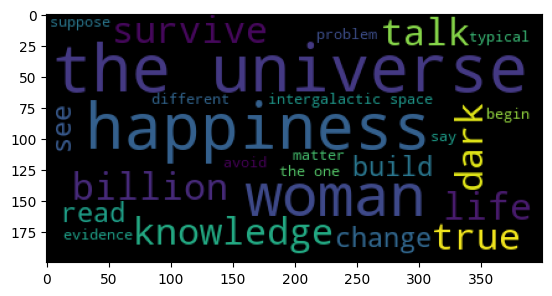

In [16]:
# https://stackoverflow.com/questions/60993778/how-to-create-wordcloud-from-lda-model
top_n = 25
# for t in range(lda_model.num_topics):
for t in range(1):
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, top_n))))
    plt.show()


In [17]:
# https://www.youtube.com/watch?v=TKjjlp5_r7o&ab_channel=PythonTutorialsforDigitalHumanities
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, words, mds='mmds', R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.343067  0.112005       1        1  15.122782
27     0.135032 -0.308129       2        1   8.783690
28     0.313817  0.106921       3        1   7.593143
16     0.183255  0.264353       4        1   6.422459
11     0.240393 -0.154730       5        1   5.266582
21    -0.001520 -0.278555       6        1   5.156136
14    -0.073714  0.273837       7        1   4.580729
6      0.242299  0.037379       8        1   4.165850
13    -0.234674 -0.139821       9        1   4.091863
22    -0.244783 -0.022624      10        1   4.049117
12    -0.160956  0.196846      11        1   3.914618
26    -0.075527 -0.234002      12        1   3.719550
1     -0.149439 -0.169338      13        1   3.285736
24     0.182572  0.008171      14        1   3.236889
2      0.020782  0.210658      15        1   2.962003
19     0.136897 -0.085620      16        1   2.810744
8      0.084451 -0.140625      17        1   2.785396
17    -0.165267  0.064142      18        1   2.571114
5     -0.095374 -0.069851      19        1   1.935976
23     0.033829  0.128711      20        1   1.862570
20     0.096457  0.120331      21        1   1.813813
29    -0.084461  0.064682      22        1   1.459963
18    -0.026328  0.071147      23        1   1.245605
4      0.004041 -0.060702      24        1   1.097078
15    -0.001334 -0.000167      25        1   0.046915
9     -0.003213  0.001212      26        1   0.004024
3     -0.003394  0.001185      27        1   0.004012
25    -0.003580  0.000890      28        1   0.003949
7     -0.003518  0.000904      29        1   0.003859
0     -0.003679  0.000792      30        1   0.003834, topic_info=            Term       Freq      Total Category  logprob  loglift
394          say  78.000000  78.000000  Default  30.0000  30.0000
557    the world  64.000000  64.000000  Default  29.0000  29.0000
10349   the gang  17.000000  17.000000  Default  28.0000  28.0000
617        woman  44.000000  44.000000  Default  27.0000  27.0000
126      believe  32.000000  32.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
286         lose   0.000064   9.768670  Topic30  -9.1878  -1.7636
470    the earth   0.000064   9.732158  Topic30  -9.1884  -1.7604
912      suppose   0.000064  15.164027  Topic30  -9.1846  -2.2001
161       design   0.000064  23.538777  Topic30  -9.1874  -2.6426
126      believe   0.000064  32.572439  Topic30  -9.1924  -2.9725

[1668 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
2624      2  0.795874               "audience
1023     11  0.574601           "united state
8069     15  0.622617  (pre-recorded applause
6463      5  0.290901                   (sigh
6463     15  0.581801                   (sigh
...     ...       ...                     ...
4700     12  0.585098          your net worth
8335     15  0.960948             your people
9365      9  0.833710             your vagina
4708     12  0.679537          your worldview
6187     19  0.717189                    zoom

[1531 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 28, 29, 17, 12, 22, 15, 7, 14, 23, 13, 27, 2, 25, 3, 20, 9, 18, 6, 24, 21, 30, 19, 5, 16, 10, 4, 26, 8, 1])

## Document Visualization of Named Entity Recognition
~~Begin preprocessing based on the [SpaCy preprocessing pipelines](https://spacy.io/usage/processing-pipelines)~~

documentation on [visualization](https://spacy.io/usage/visualizers). Note that these visualization tools need access to the SpaCy docs directly. This would require a change in the previous implementation of the preprocessing pipeline.


In [18]:
temp_doc = text_preprocessing(df['transcript'][0], get_doc=True)

sentence_spans = list(temp_doc.sents)
print("%d sentences" % (len(sentence_spans)))
short = int(len(sentence_spans) / 16)
print("shorten to %d sentences" % (short))
sentence_spans = sentence_spans[short*3:short*4]
print("%d sentences" % (len(sentence_spans)))

spacy.displacy.render(sentence_spans, style='ent')

# spacy.displacy.render(sentence_spans, style='dep')

263 sentences
shorten to 16 sentences
16 sentences


## Attempt Document Summarization following [tutorial](https://towardsdatascience.com/text-summarization-for-clustering-documents-2e074da6437a)
Note that this does not use LDA at all.

alternatively, look at some of the following:
[activestate.com](https://www.activestate.com/blog/how-to-do-text-summarization-with-python/)

[extractive text summarization using nltk](https://www.mygreatlearning.com/blog/text-summarization-in-python/)

[spacy extractive text summarization](https://betterprogramming.pub/extractive-text-summarization-using-spacy-in-python-88ab96d1fd97)

In [19]:
SUBJECTS = ["nsubj", "nsubjpass", "csubj", "csubjpass", "agent", "expl"]
OBJECTS = ["dobj", "dative", "attr", "oprd"]

def subjects_from_conjunction(subjects):
    additional_subjects= []
    for subject in subjects:
        # get everything to the right of the subject
        rights = list(subject.rights)
        right_dendencies = {token.lower_ for token in rights}
        if "and" in right_dendencies:
            additional_subjects.extend([token for token in rights if token.dep_ in SUBJECTS or token.pos_ == "NOUN"])
            if len(additional_subjects) > 0:
                additional_subjects.extend(subjects_from_conjunction(additional_subjects))
#         print("Additional Subjects:", additional_subjects)
    return additional_subjects

def objects_from_Conjunctions(objects):
    additional_objects= []
    for object in objects:
        # get everything to the right of the object
        rights = list(object.rights)
        right_dendencies = {token.lower_ for token in rights}
        if "and" in right_dendencies:
            additional_objects.extend([token for token in rights if token.dep_ in OBJECTS or token.pos_ == "NOUN"])
            if len(additional_objects) > 0:
                additional_objects.extend(objects_from_Conjunctions(additional_objects))
#     print("Objects from Conjunctions:", additional_objects)
    return additional_objects

def findSubjects(token):
    head = token.head
    while head.pos_ != "VERB" and head.pos_ != "NOUN" and head.head != head:
        head = head.head
    if head.pos_ == "VERB":
#         print("verb heads:", head)
        subjects = [tok for tok in head.lefts if tok.dep_ == "SUB"]
        if len(subjects) > 0:
            verb_is_negated = isNegated(head)
            subjects.extend(subjects_from_conjunction(subjects))
            return subjects, verb_is_negated
        elif head.head != head:
            return findSubjects(head)
    elif head.pos_ == "NOUN":
#         print("noun heads:", head)
        return [head], isNegated(token)
    return [], False

def isNegated(token):
    negations = {"no", "not", "n't", "never", "none", "dont"}
    for dep in list(token.lefts) + list(token.rights):
        if dep.lower_ in negations:
            return True
    return False

def objects_from_prepositions(dependencies):
    objects = []
    for dependency in dependencies:
        if dependency.pos_ == "ADP" and dependency.dep_ == "prep":
            objects.extend([token for token in dependency.rights if token.dep_  in OBJECTS or 
                                                     (token.pos_ == "PRON" and token.lower_ == "me")
                        ])
#     print("objects from prepositions:", objects)
    return objects


def all_subjects(verb):
    verbNegated = isNegated(verb)
    subjects = [token for token in verb.lefts if (token.dep_).lower() in SUBJECTS and token.pos_ != "DET"]
#     print()
#     print(verb, subjects)
    if len(subjects) > 0:
        subjects.extend(subjects_from_conjunction(subjects))
    else:
        foundSubjects, verbNegated = findSubjects(verb)
        subjects.extend(foundSubjects)
#     print("subjects, verb negated:", subjects, verbNegated)
    return subjects, verbNegated

def all_objects(v):
    # A right-child of the token= rights
    rights = list(v.rights)
    objetcs = [tok.head.orth_ for tok in rights if (tok.dep_).lower() in OBJECTS]
    objects = [tok for tok in rights if (tok.dep_).lower() in OBJECTS]
    
#     print("objects:", objects)
    objetcs.extend(objects_from_prepositions(rights))
    if len(objects) > 0:
        objetcs.extend(objects_from_Conjunctions(objects))
    return v, objects

def custom_summarize(tokens):
    summary_ = []
    summary = []
    verbs = [token for token in tokens if token.pos_ == "VERB" and token.dep_ != "aux"]
#     print("verbs:", verbs)
    for verb in verbs:
        subjects, verbNegated = all_subjects(verb)
#         if len(subjects)>0:
#             print("\nSubjects, Verb ,Negations:", subjects, verb, verbNegated)

        # evaluate verb only if there are subjects
        if len(subjects) > 0:
            verb, objects = all_objects(verb)
#             print("Verb, Verb Negations:", verb, objects)
            for subject in subjects:
                for object in objects:
                    objNegated = isNegated(object)
                    summary_.append((subject.lower_, "NOT " + verb.lower_ if verbNegated or 
                                                                 objNegated 
                                                                else verb.lower_, object.lower_
                                ))
    for tuple_item in summary_:
        summary_item = " ".join(item for item in tuple_item)
        summary.append(summary_item)
    return ".".join(sentence for sentence in summary)

# notes_data["SUMMARY"] = notes_data["TEXT"].apply(lambda text: custom_summarize(nlp(text)))
# notes_data["SUMMARY"] = notes_data["SUMMARY"].apply(lambda text: re.sub(r"(\b)(P|p)(t|T)(\b)", "patient", text))
summary = custom_summarize(temp_doc)
summary = summary.replace(".", ". ")
summary

'it put us. we have no idea. i have an interest. everybody has an interest. they pin you. i have a big interest. we have a huge vested interest. education take us. children starting school. nobody has a clue. have is a person. there is a person. who found a talent. all kids have tremendous talents. we squander them. we treat it. i heard a great story. this girl paid attention. i drawing a picture. you remember the story. mel gibson did the sequel. you seen it. james got the part. we had the place. the place crammed full. the three boys came four-year-olds. they put these boxes. i bring you. i bring gold. i bring you. i bring myrrh. frank sent this. kids take a chance. they have a go. most kids lost that capacity. we run our companies. we stigmatize mistakes. we running national education systems. we educating people. picasso said this. he said artists. i believe this. you imagine what a seamless transition. a place called snitterfield. it confusing everybody. i got two kids. he loved i

## other useful information

[more about text summarization and approaches](https://www.machinelearningplus.com/nlp/text-summarization-approaches-nlp-example/)

[NLP text summariazation apis](https://www.assemblyai.com/blog/text-summarization-nlp-5-best-apis/?utm_source=google&utm_medium=cpc&utm_campaign=text_summarization&utm_term=summarize%20text%20nlp)

[text summarization github](https://github.com/g-deoliveira/TextSummarization)

[online summary site](https://smmry.com/)

### two types of text summarization:
1. extractive text summarization
    - model pulls out the most important sentences from the original text
    - easy way to perform would be to count the occurances of each word in the document then sum the total occurrences for each word in a sentence then keep the top x sentences. Simmilar to the TextRank algorithm.
    - Try TextRank, LexRank, Latent Semantic Analysis
    - Could probably do this using the topics from LDA as well...
2. abstractive text summarization
    - requires the model to generate summaries
    - Transformers, GAN-based-methods (Generative Adversarial Network for Abstractive Text Summarization), 

### Paid APIs
1. AssemblyAI’s Auto Chapters API
    - runs speach-to-text API then applies text summarization over the stream to give a one paragraph summary and single sentence headline for each chapter.
2. plnia’s Text Summarization API
3. Microsoft Azure Text Summarization
4. MeaningCloud’s Automatic Summarization
5. NLP Cloud Summarization API

## Gensim TextRank for Text Summarization
Can no longer be used because the summarization module was removed from Gensim in version 4.0. Though, we could probably create something simmilar ourselves. Many users report that it was not that good of a summarization tool unfortunatly.

## Text Summarization with Sumy
### LexRank
### Luhn
### Latent Semantic Analysis (LSA)
### KL-Sum